In [1]:
import os
import yaml
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

from typing import Callable, Tuple, List, Union, Dict
from pydantic import BaseModel

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchmetrics

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf

from data_utils import *

In [50]:
class ExperimentSetting2(BaseModel):
    """Dataset from which embeddings are sourced from"""
    dataset: str
    """subset of the dataset to be used"""
    subset: str
    """Number of initial datapoints (to build the models)"""
    n_init: int
    """Number of total datapoints evaluated"""
    n_total: int
    """Standardization flag for design matrix"""
    standardize:bool
    """Model (type) from which the embedding vectors are sourced from"""
    model: str
    """Layer (ID) of the neural network to load embeddings from"""
    layer: int 
    """Level of training (0: embryonic - 4: converged)"""
    epochs: int
    """Similarity measure"""
    metric: str
    """Objective function"""
    objective: str
    """Acquisition function"""
    acquisition: str
    """Modulus of bound value of optimization problem"""
    bound: float
    """Beta value for UCB"""
    beta: float
    """Dimension reduction technique"""
    dim_red: str
    """Effective dimension (in case of dimension reduction)"""
    dim_eff: int
    
class Experiment2():
    def __init__(self, config:ExperimentSetting2):
        self.dataset     = config.dataset
        self.subset      = config.subset
        self.n_init      = config.n_init
        self.n_total     = config.n_total
        self.standardize = config.standardize
        self.model       = config.model
        self.layer       = config.layer
        self.epochs      = config.epochs
        self.metric      = config.metric
        self.objective   = config.objective
        self.acquisition = config.acquisition
        self.bound       = config.bound
        self.beta        = config.beta
        self.dim_red     = config.dim_red
        self.dim_eff     = config.dim_eff
        
        # Check Inputs
        assert self.n_init > 0,  'Input `n_init` must be positive.'
        assert self.n_total > 0, 'Input `n_total` must be positive.'
        assert self.n_total > self.n_init, f'Input `n_total`={self.n_total} must be larger than `n_init`={self.n_init}.'
        assert self.bound > 0, "(Modulus of componentwise) bound must be positive float."
        assert self.metric in ['cosine', 'l2', 'l1'], "Unknown `metric`"
        assert self.objective in ['mu_tr', 'q935_tr', 'sig_tr', 'mu+sig_tr', 'conv1_tr', 'conv2_tr', 'conv3_tr', 'conv4_tr', 'conv1+label_tr', 'conv2+label_tr', 'conv3+label_tr', 'conv4+label_tr'], "Unknown `objectie`"
        assert self.acquisition in ['ucb', 'ei'], "Acquisition function must be eitgher `ucb` or `ei`."
        assert self.epochs in [0, 5, 20, 99], "Layer id not available. Pick from {0, 5, 20, 99}."
        assert (self.dim_red is None) | (self.dim_red in ['pca', 'svd']), "Dimension reduction technique"
        
        # Set metric
        if(self.metric=='cosine'):
            self.dist = nn.CosineSimilarity()
        elif(self.metric=='l1'):
            self.dist = lambda a,b: lp(a,b,p=1)
        elif(self.metric=='l2'):
            self.dist = lambda a,b: lp(a,b,p=2)
        else:
            raise NotImplementedError("Only `cosine` (similiarity), `l1` and `l2` implemented.")
            
        # Load data
        # - load tables
        self.df_f_tr = pd.read_csv(f'./tables/df_{self.dataset}_{self.subset}.csv')
        self.df_f_te = pd.read_csv(f'./tables/df_{self.dataset}_{self.subset}.csv')
        
        # - subset data
        #self.df_f_tr = self.df_f_tr[0:500]
        #self.df_f_te = self.df_f_te[0:500]
        
        # - emb
        X_tr, y_tr, X_te, y_te = getEmbXy(self.epochs, self.layer)
        # - store raw data
        self.X_tr = X_tr
        self.X_te = X_te
        
        # - convert
        X_tr = torch.tensor(X_tr).type(torch.float64)
        X_te = torch.tensor(X_te).type(torch.float64)
        
        # - siubset
        self.X_tr = X_tr
        self.X_te = X_te

        # - load raw data
        X_tr_raw, _, X_te_raw, _ = getEmbXy(-1, self.layer, True)
        self.X_tr_raw = X_tr_raw
        self.X_te_raw = X_te_raw
        
        # convert data
        train_X = torch.tensor(X_tr, dtype=torch.float64)
        train_Y = torch.tensor(self.df_f_tr[self.objective])
        train_Y = train_Y.reshape(len(train_Y), -1)

        # dimension reduction
        if(self.dim_red=='pca'):
            if(self.dim_eff==-1):
                U, S, V  = torch.pca_lowrank(train_X) 
            else:
                U, S, V  = torch.pca_lowrank(train_X, q=self.dim_eff)
            # store
            self.U = U
            self.V = V
            self.S = S
            
            # projection
            proj_train_X  = torch.matmul(train_X, V)        # d=6
            appr          = torch.matmul(proj_train_X, V.T)
            
            # - store raw data's projection
            self.X_tr_proj = torch.matmul(self.X_tr, V)
            self.X_te_proj = torch.matmul(self.X_te, V)
            
            # - assess quality
            total_var = torch.var(train_X)
            total_var_approx = torch.var(appr)
            cum_perc = (total_var_approx / total_var) * 100
            print(f'Dim. reduction via {self.dim_red.upper()} from d={train_X.shape[1]} to d_eff={proj_train_X.shape[1]}.\nMaintaining {cum_perc:.2f}% of variation.')
        else:
            proj_train_X = train_X

        # - standardize
        if(self.standardize):
            print('Min max')
            # min max
            self.train_X = min_max(proj_train_X)
            
            print('Standardize!')
            #self.train_X = standardize(self.train_X)
            self.train_Y = standardize(train_Y)
            #self.train_Y = train_Y
            
           

        # cast to float64
        self.train_X = self.train_X.type(torch.float64)
        self.train_Y = self.train_Y.type(torch.float64)

        pass
    
    def fit(self, n_max:int=1000, rndVal:int=5892, verbose:bool=False) -> None:
        # replicable experiment
        np.random.seed(rndVal)
        rndIndex = np.random.choice(range(len(self.train_X)), n_max, False)
        
        # subset data
        X = self.train_X[rndIndex,]
        Y = self.train_Y[rndIndex,]
        
        # Gaussian Process
        self.gp  = SingleTaskGP(X, Y)
        self.mll = ExactMarginalLogLikelihood(self.gp.likelihood, self.gp)
        
        # - fit
        fit_gpytorch_mll(self.mll)
        
        if(verbose):
            print("Fitting of GP complete.")
        
        # Acquisition function
        if(self.acquisition=='ucb'):
            self.acq_fun = UpperConfidenceBound(self.gp, beta=self.beta)
        else:
            raise NotImplementedError('Only `ucb` implemented for acquisition function.')
        
        # Bounds
        self.bounds = torch.stack([(-1.) * self.bound * torch.ones(X.shape[1]), 
                                   self.bound * torch.ones(X.shape[1])])
        
        #return
        if(verbose):
            print("Bounds and acquisition defined.")
        
        # AFO
        x_cand, acq_value = optimize_acqf(
            self.acq_fun, bounds=self.bounds, q=1, num_restarts=10, raw_samples=50,
        )
        
        if(verbose):
            print("Acquisition function.")
        
        # register candidate 
        self.x_cand = x_cand.type(torch.float64)
        self.acq_value = acq_value
        
        # flag
        self.optimized=True
        
        pass
    
    def getXOpt(self, asImage:bool=False, mode:str='train', method='kNN') -> torch.tensor:
        '''
        Return the optimal candidate
        '''
        assert self.optimized, "Launch `.fit()` before requesting the optimum candidate!"
        assert mode.lower() in ['train', 'test'], "`mode` must be either `train` or `test` for respective lookup of the best image."
        
        if(method.lower()!='knn'):
            raise NotImplementedError("Did not implement any of those methods to translate embeddinng vector to image except nearest-neighbor lookup (`1NN`)!")
        
        if(asImage):
            # closest index
            if(method.lower()=='knn'):
                # distance matrix: d_proj -> d_embedding
                v_cand = self.x_cand @ self.V.T
                if(mode=='train'):
                    self.D = self.dist(v_cand, self.X_tr)
                else:
                    self.D = self.dist(v_cand, self.X_te)
                
                # index
                if(self.metric=='cosine'):
                    self.i_star = self.D.argmax()
                else:
                    self.i_star = self.D.argmin()
                
                # look up clo
                if(mode!='train'):
                    return self.X_te_raw[self.i_star]
                
                return self.X_tr_raw[self.i_star]
                
        
        return self.x_cand

In [51]:
# Setup of Experiment
# - load YAML
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# - set setting
setting = ExperimentSetting2(**config)

# - define experiment 
exp2 = Experiment2(setting)

# - run experiment
exp2.fit(n_max=500)
img = exp2.getXOpt(asImage=True)

/tmp/ipykernel_1890086/730410305.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = torch.tensor(X_tr, dtype=torch.float64)


Dim. reduction via PCA from d=256 to d_eff=6.
Maintaining 76.93% of variation.
Min max
Standardize!


/eagle/candle_aesp/siebenschuh/envs_/diff/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


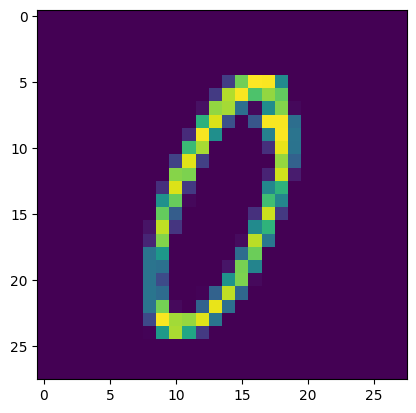

In [52]:
plt.imshow(img)